model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

['To', 'be', 'or', 'not', 'to', 'be', ',', 'that', 'is', 'the']


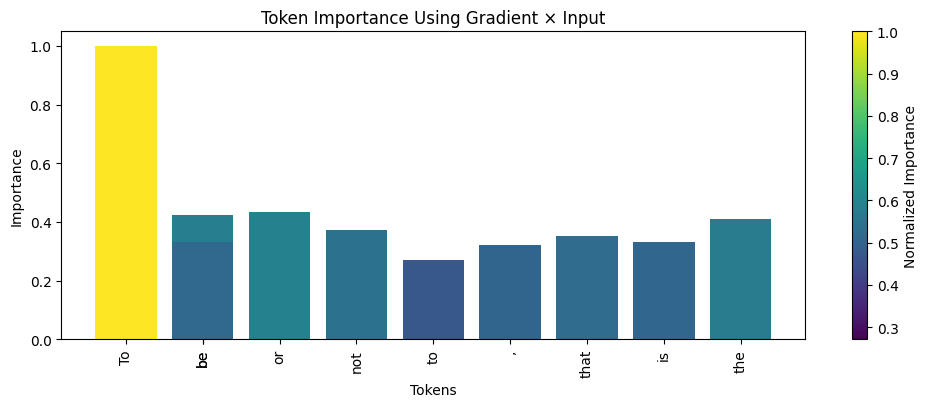

In [ ]:
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch


model_name = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
inputs = tokenizer("To be or not to be, that is the", return_tensors="pt")
input_ids = inputs["input_ids"]

# Get embeddings and clone to make them a leaf in the graph
embeddings = model.transformer.wte(input_ids)
embeddings = embeddings.clone().detach()
embeddings.requires_grad = True

# Perform forward pass using embeddings
model.eval()
outputs = model(inputs_embeds=embeddings)
last_token_logits = outputs.logits[0, -1, :]


target_id = tokenizer.convert_tokens_to_ids('question')
target_logit = last_token_logits[target_id]

# Gradient × Input calculation
target_logit.backward()
grad_input = embeddings.grad * embeddings

# Sum of absolute gradient input values across embedding dimensions
importance_scores = grad_input.abs().sum(dim=-1).squeeze()

# Normalize scores for better visualization
importance_scores /= importance_scores.max()
tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
tokens = [i.replace('Ġ', '') for i in tokens]
#print(tokens)

fig, ax = plt.subplots(figsize=(12, 4))
colors = plt.cm.viridis(importance_scores.detach().numpy())
bars = ax.bar(tokens, importance_scores.detach().numpy(), color=colors)
ax.set_xlabel('Tokens')
ax.set_ylabel('Importance')
ax.set_title('Token Importance Using Gradient × Input')
ax.set_xticks(tokens)
ax.set_xticklabels(tokens, rotation=90)
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=importance_scores.min(), vmax=importance_scores.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Normalized Importance')
plt.savefig('Top tokens.jpg', bbox_inches='tight', format='jpeg')
plt.show()
